In [1]:
import pandas as pd
import numpy as np
import h5py

# Load CSV
df = pd.read_csv("merge.csv")

# Filter earthquakes with valid p_arrival_samples and magnitude > 1
df_eq = df[(df.trace_category == 'earthquake_local') & 
           (df.source_magnitude > 1) & 
           (~df.p_arrival_sample.isna()) &  # Not NaN
           (df.p_arrival_sample > 0)        # Greater than 0
          ].sample(n=15000, random_state=42, replace=False)

# Sample noise data
df_noise = df[df.trace_category == 'noise'].sample(n=10000, random_state=42, replace=False)

# Combine the dataframes
combined_df = pd.concat([df_eq, df_noise], ignore_index=True)

# Prepare to load waveforms
H5_PATH = "merge.hdf5"
all_trace_names = combined_df["trace_name"].tolist()
num_waveforms = len(all_trace_names)

# Create empty arrays to store waveforms and their metadata
waveforms = []
valid_trace_names = []

# Load waveforms while keeping track of which ones were successfully loaded
with h5py.File(H5_PATH, "r") as h5_file:
    for trace_name in all_trace_names:
        hdf5_path = f"data/{trace_name}"
        if hdf5_path in h5_file:
            waveform = np.array(h5_file[hdf5_path])
            waveforms.append(waveform)
            valid_trace_names.append(trace_name)
        else:
            print(f"Warning: {hdf5_path} not found in HDF5 file.")

# Convert to numpy array
X_numpy_waveform = np.array(waveforms, dtype=np.float32)

# Filter the dataframe to only include traces that were successfully loaded
filtered_df = combined_df[combined_df["trace_name"].isin(valid_trace_names)]

# Now we can shuffle while maintaining the connection between metadata and waveforms
shuffle_indices = np.random.permutation(len(X_numpy_waveform))
X_numpy_waveform_shuffled = X_numpy_waveform[shuffle_indices]
filtered_df_shuffled = filtered_df.iloc[shuffle_indices].reset_index(drop=True)

print(f"Loaded {len(X_numpy_waveform_shuffled)} total waveforms with shape: {X_numpy_waveform_shuffled.shape}")
print(f"Number of earthquakes: {len(filtered_df_shuffled[filtered_df_shuffled.trace_category == 'earthquake_local'])}")
print(f"Number of noise samples: {len(filtered_df_shuffled[filtered_df_shuffled.trace_category == 'noise'])}")
print(f"Number of NaN p_arrivals: {filtered_df_shuffled['p_arrival_sample'].isna().sum()}")
print(f"Number of non-zero, non-NaN p_arrivals: {filtered_df_shuffled['p_arrival_sample'].dropna().ne(0).sum()}")

C:\Users\wwwra\AppData\Local\Temp\ipykernel_17100\1330425274.py:6: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merge.csv")


Loaded 25000 total waveforms with shape: (25000, 6000, 3)
Number of earthquakes: 15000
Number of noise samples: 10000
Number of NaN p_arrivals: 10000
Number of non-zero, non-NaN p_arrivals: 15000


In [2]:
print(f"Number of noise samples: {len(filtered_df_shuffled[filtered_df_shuffled.trace_category == 'noise'])}")
print(f"Number of NaN p_arrivals: {filtered_df_shuffled['p_arrival_sample'].isna().sum()}")
print(f"Number of non-zero, non-NaN p_arrivals: {filtered_df_shuffled['p_arrival_sample'].dropna().ne(0).sum()}")

Number of noise samples: 10000
Number of NaN p_arrivals: 10000
Number of non-zero, non-NaN p_arrivals: 15000


In [3]:
print("P-arrival sample indices (first 20):", filtered_df_shuffled["p_arrival_sample"].values[:20])
print(f"Min P-arrival: {filtered_df_shuffled['p_arrival_sample'].min()}, Max P-arrival: {filtered_df_shuffled['p_arrival_sample'].max()}")


P-arrival sample indices (first 20): [ nan  nan 400.  nan 499. 700. 900. 800. 500. 400.  nan  nan  nan 700.
  nan 629. 699. 601. 600.  nan]
Min P-arrival: 25.0, Max P-arrival: 2048.6


In [4]:
filtered_df_shuffled["p_arrival_sample"] = pd.to_numeric(filtered_df_shuffled["p_arrival_sample"], errors='coerce').astype(float)
filtered_df_shuffled["p_arrival_sample"] = filtered_df_shuffled["p_arrival_sample"].round().astype("Int64")  # Keeps NaNs


In [5]:
print("P-arrival sample indices (first 20):", filtered_df_shuffled["p_arrival_sample"].values[:20])
print(f"Min P-arrival: {filtered_df_shuffled['p_arrival_sample'].min()}, Max P-arrival: {filtered_df_shuffled['p_arrival_sample'].max()}")


P-arrival sample indices (first 20): <IntegerArray>
[<NA>, <NA>,  400, <NA>,  499,  700,  900,  800,  500,  400, <NA>, <NA>, <NA>,
  700, <NA>,  629,  699,  601,  600, <NA>]
Length: 20, dtype: Int64
Min P-arrival: 25, Max P-arrival: 2049


In [6]:
p_arrivals = filtered_df_shuffled["p_arrival_sample"].values


In [ ]:
import os
import numpy as np
import pandas as pd

SAVE_DIR = "seismic_dataset"
waveform_dir = os.path.join(SAVE_DIR, "waveforms")

if not os.path.exists(waveform_dir):
    raise FileNotFoundError(f" Waveform directory not found: {waveform_dir}")

metadata_path = os.path.join(SAVE_DIR, "metadata.csv")

if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"Metadata CSV not found: {metadata_path}")

metadata_df = pd.read_csv(metadata_path)

print(f"Loaded metadata with {len(metadata_df)} records.")
print(metadata_df.head())

earthquake_metadata = metadata_df[metadata_df['trace_category'] == 'earthquake_local']
noise_metadata = metadata_df[metadata_df['trace_category'] == 'noise']

earthquake_metadata_selected = earthquake_metadata.head(15000)
noise_metadata_selected = noise_metadata.head(10000)

metadata_df_selected = pd.concat([earthquake_metadata_selected, noise_metadata_selected])

metadata_df_selected = metadata_df_selected.sample(frac=1, random_state=42).reset_index(drop=True)

metadata_df_selected["p_arrival_sample"] = metadata_df_selected["p_arrival_sample"].fillna(0).astype(int)


waveforms = []
p_arrivals = []  
trace_categories = []  


for index, file_name in metadata_df_selected["file_name"].items():
    file_path = os.path.join(waveform_dir, file_name)
    
    if os.path.exists(file_path):
        waveform = np.load(file_path)  
        waveforms.append(waveform)
        
        p_arrival_sample = metadata_df_selected["p_arrival_sample"].iloc[index]
        p_arrivals.append(p_arrival_sample)

        trace_category = metadata_df_selected["trace_category"].iloc[index]
        trace_categories.append(trace_category)
    else:
        print(f" Warning: File not found {file_name}")


waveforms = np.array(waveforms, dtype=object)
p_arrivals = np.array(p_arrivals)
trace_categories = np.array(trace_categories)

print(f"Loaded {len(waveforms)} waveforms.")
print(f"Example waveform shape: {waveforms[0].shape}")  

print(f"Loaded metadata for {len(metadata_df_selected)} waveforms.")
print(metadata_df_selected.head())

print(f"First 3 p_arrival_sample values: {p_arrivals[:3]}")
print(f"First 3 trace_category values: {trace_categories[:3]}")

print(f"Waveforms shape: {waveforms.shape}")
print(f"P_arrival_sample shape: {p_arrivals.shape}")
print(f"Trace_categories shape: {trace_categories.shape}")


✅ Loaded metadata with 25000 records.
                        file_name    trace_category  source_magnitude  \
0   WMTN.ET_20180116083718_NO.npy             noise               NaN   
1   FNSB.CN_20180115055536_NO.npy             noise               NaN   
2   ARSB.KR_20130612170738_EV.npy  earthquake_local              2.60   
3  HASLI.CH_20180115020724_NO.npy             noise               NaN   
4  KAN06.GS_20140915190342_EV.npy  earthquake_local              2.04   

   p_arrival_sample  
0               NaN  
1               NaN  
2             400.0  
3               NaN  
4             499.0  
Loaded 5000 waveforms.
Example waveform shape: (6000, 3)
Loaded metadata for 5000 waveforms.
                       file_name    trace_category  source_magnitude  \
0   DSC.CI_20160714172433_EV.npy  earthquake_local              2.14   
1  PACP.BK_20070606012000_EV.npy  earthquake_local              2.45   
2  D25K.TA_20180812191000_EV.npy  earthquake_local              2.70   
3  GASB.BK

In [ ]:
import numpy as np

waveforms = np.array(waveforms, dtype=np.float32)

print(f"Converted waveforms to NumPy array with shape: {waveforms.shape}")


Converted waveforms to NumPy array with shape: (5000, 6000, 3)


In [ ]:
min_vals = np.min(waveforms, axis=1, keepdims=True)
max_vals = np.max(waveforms, axis=1, keepdims=True)


waveforms_minmax = (waveforms - min_vals) / (max_vals - min_vals + 1e-8)

print(f"Applied Min-Max Normalization. Shape: {waveforms_minmax.shape}")


Applied Min-Max Normalization. Shape: (5000, 6000, 3)


In [ ]:

mean_vals = np.mean(waveforms, axis=1, keepdims=True)
std_vals = np.std(waveforms, axis=1, keepdims=True)


std_vals[std_vals == 0] = 1e-8  

waveforms_zscore = (waveforms - mean_vals) / std_vals

print(f"Applied Z-score Standardization. Shape: {waveforms_zscore.shape}")


Applied Z-score Standardization. Shape: (5000, 6000, 3)


In [ ]:
print(f"Waveforms shape: {waveforms_zscore.shape}")
print(f"P_arrival_sample shape: {p_arrivals.shape}")
print(f"Trace_categories shape: {trace_categories.shape}")


Waveforms shape: (5000, 6000, 3)
P_arrival_sample shape: (5000,)
Trace_categories shape: (5000,)


In [ ]:
from sklearn.model_selection import train_test_split


waveforms_zscore = np.array(waveforms_zscore)
p_arrival_sample = np.array(p_arrival_sample)
trace_categories = np.array(trace_categories)


waveforms_train, waveforms_temp, p_train, p_temp, cat_train, cat_temp = train_test_split(
    waveforms_zscore, p_arrivals, trace_categories, test_size=0.3, random_state=42
)


waveforms_val, waveforms_test, p_val, p_test, cat_val, cat_test = train_test_split(
    waveforms_temp, p_temp, cat_temp, test_size=0.5, random_state=42
)

print(f"Train: {len(waveforms_train)}, Validation: {len(waveforms_val)}, Test: {len(waveforms_test)}")


Train: 3500, Validation: 750, Test: 750


In [ ]:

gaussian_sigma = 0.5 
sample_rate=100
gaussian_sigma_samples = gaussian_sigma * sample_rate  

def apply_gaussian_labels(waveforms, p_arrival_samples, trace_categories):
    labels = []

    for i, (waveform, p_arrival_sample, category) in enumerate(zip(waveforms, p_arrival_samples, trace_categories)):
        n_samples = waveform.shape[0]
        full_label = np.zeros(n_samples)
        is_earthquake = category == 'earthquake_local'

        if is_earthquake and p_arrival_sample > 0:
            start_sample = max(0, int(p_arrival_sample - 3 * gaussian_sigma_samples))
            end_sample = min(n_samples, int(p_arrival_sample + 3 * gaussian_sigma_samples + 1))

            for t in range(start_sample, end_sample):
                full_label[t] = np.exp(-0.5 * ((t - p_arrival_sample) / gaussian_sigma_samples) ** 2)

        labels.append(full_label)

    return np.array(labels)


y_train = apply_gaussian_labels(waveforms_train, p_train, cat_train)
y_val = apply_gaussian_labels(waveforms_val, p_val, cat_val)
y_test = apply_gaussian_labels(waveforms_test, p_test, cat_test)

print(f" Gaussian labels applied with σ = 0.5 sec. Shapes: Train {y_train.shape}, Val {y_val.shape}, Test {y_test.shape}")


 Gaussian labels applied with σ = 0.5 sec. Shapes: Train (3500, 6000), Val (750, 6000), Test (750, 6000)


In [ ]:
def segment_data(x, y, window_samples, stride_samples):
    X_windows = []
    y_windows = []
    num_waveforms = x.shape[0]
    
    for i in range(num_waveforms):
        waveform = x[i]
        label = y[i]
        n_samples = waveform.shape[0]
        
        for start in range(0, n_samples - window_samples + 1, stride_samples):
            end = start + window_samples
            X_windows.append(waveform[start:end, :])
            y_windows.append(label[start:end])
    return np.array(X_windows), np.array(y_windows)
window_samples = 500  
stride_samples = 250   
X_train_final, y_train_final = segment_data(waveforms_train, y_train, window_samples, stride_samples)
X_val_final, y_val_final = segment_data(waveforms_val, y_val, window_samples, stride_samples)
X_test_final, y_test_final = segment_data(waveforms_test, y_test, window_samples, stride_samples)

print(f" Final X_train shape: {X_train_final.shape}, y_train shape: {y_train_final.shape}")

print(f" Final X_test shape: {X_test_final.shape}, y_train shape: {y_test_final.shape}")

 Final X_train shape: (80500, 500, 3), y_train shape: (80500, 500)
 Final X_test shape: (17250, 500, 3), y_train shape: (17250, 500)


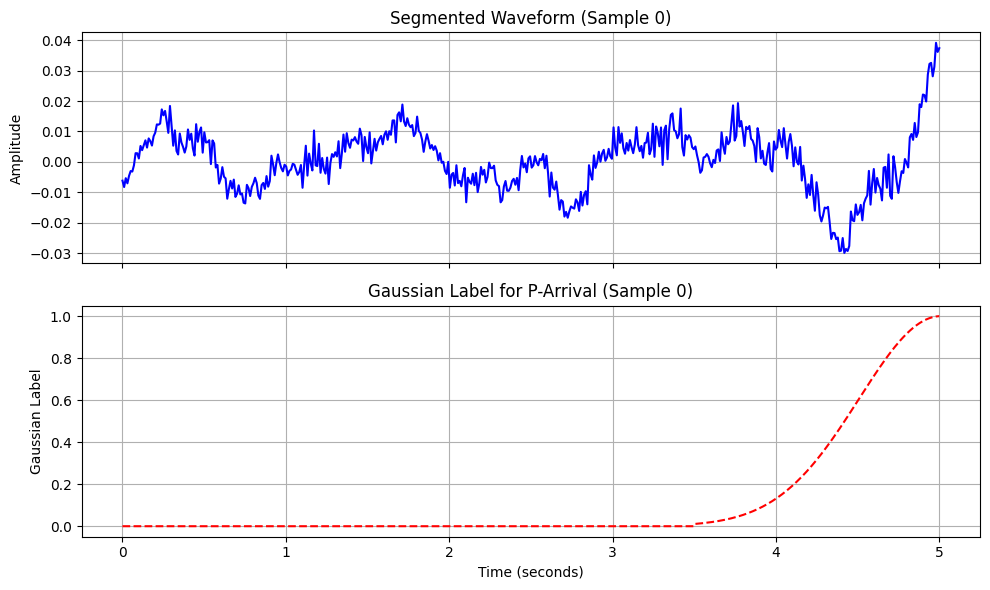

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


sample_idx = 0


waveform_segment = X_train_final[sample_idx]  
label_segment = y_train_final[sample_idx] 


time_segment = np.linspace(0, window_samples / 100, window_samples) 


fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)


axes[0].plot(time_segment, waveform_segment[:, 0], color="blue")
axes[0].set_ylabel("Amplitude")
axes[0].set_title(f"Segmented Waveform (Sample {sample_idx})")
axes[0].grid()


axes[1].plot(time_segment, label_segment, color="red", linestyle="dashed")
axes[1].set_xlabel("Time (seconds)")
axes[1].set_ylabel("Gaussian Label")
axes[1].set_title(f"Gaussian Label for P-Arrival (Sample {sample_idx})")
axes[1].grid()


plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, Conv1DTranspose, MultiHeadAttention, LayerNormalization,
                                     Dropout, Concatenate, Cropping1D, UpSampling1D)
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=3, activation='relu', dilation_rate=1):
   
    x = Conv1D(filters, kernel_size, padding='same', activation=activation, dilation_rate=dilation_rate)(x)
    x = Conv1D(filters, kernel_size, padding='same', activation=activation, dilation_rate=dilation_rate)(x)
    return x

def self_attention_block(x, num_heads=4, key_dim=64):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = LayerNormalization()(x + attn_output)
    return x

def unet_plus_plus_dilated(input_shape=(500, 3), num_classes=1):  
    inputs = Input(input_shape)

    c1 = conv_block(inputs, 64, dilation_rate=1)  
    d1 = Conv1D(64, 3, padding='same', activation='relu', dilation_rate=2)(c1)  

    c2 = conv_block(d1, 128, dilation_rate=2)
    d2 = Conv1D(128, 3, padding='same', activation='relu', dilation_rate=4)(c2)

    c3 = conv_block(d2, 256, dilation_rate=4)
    d3 = Conv1D(256, 3, padding='same', activation='relu', dilation_rate=8)(c3)

    c4 = conv_block(d3, 512, dilation_rate=8)
    d4 = Conv1D(512, 3, padding='same', activation='relu', dilation_rate=16)(c4)

    c5 = conv_block(d4, 1024, dilation_rate=16)
    c5 = Dropout(0.5)(c5)

    c5 = self_attention_block(c5)

    u4 = UpSampling1D(size=2)(c5)
    u4 = Conv1D(512, 3, padding='same', activation='relu')(u4)  
    u4 = Cropping1D(cropping=(0, u4.shape[1] - c4.shape[1]))(u4) 
    u4 = Concatenate()([c4, u4])
    u4 = conv_block(u4, 512)

    u3 = UpSampling1D(size=2)(u4)
    u3 = Conv1D(256, 3, padding='same', activation='relu')(u3)
    u3 = Cropping1D(cropping=(0, u3.shape[1] - c3.shape[1]))(u3)
    u3 = Concatenate()([c3, u3])
    u3 = conv_block(u3, 256)

    u2 = UpSampling1D(size=2)(u3)
    u2 = Conv1D(128, 3, padding='same', activation='relu')(u2)
    
    u2 = Cropping1D(cropping=(0, u2.shape[1] - c2.shape[1]))(u2)
    u2 = Concatenate()([c2, u2])
    u2 = conv_block(u2, 128)

    u1 = UpSampling1D(size=2)(u2)
    u1 = Conv1D(64, 3, padding='same', activation='relu')(u1)
    u1 = Cropping1D(cropping=(0, u1.shape[1] - c1.shape[1]))(u1)
    u1 = Concatenate()([c1, u1])
    u1 = conv_block(u1, 64)

    outputs = Conv1D(num_classes, 1, activation='linear')(u1)

    model = Model(inputs, outputs)
    return model


model = unet_plus_plus_dilated(input_shape=(500, 3))  
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 500, 64)      640         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 500, 64)      12352       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 500, 64)      12352       ['conv1d_1[0][0]']               
                                                                                              

In [ ]:
import tensorflow as tf
import gc

tf.keras.backend.clear_session()
gc.collect()


16774

In [ ]:
import tensorflow as tf
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

BATCH_SIZE = 8  

X_train_final = np.array(X_train_final, dtype=np.float16)
y_train_final = np.array(y_train_final, dtype=np.float16)
X_val_final = np.array(X_val_final, dtype=np.float16)
y_val_final = np.array(y_val_final, dtype=np.float16)

def create_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
    return dataset

train_dataset = create_dataset(X_train_final, y_train_final)
val_dataset = create_dataset(X_val_final, y_val_final)



model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae']
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Physical devices cannot be modified after being initialized
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
Epoch 1/10
10063/10063 [==============================] - 3123s 307ms/step - loss: 0.0076 - mae: 0.0221 - val_loss: 0.0070 - val_mae: 0.0188
Epoch 2/10
10063/10063 [==============================] - 3341s 332ms/step - loss: 0.0052 - mae: 0.0154 - val_loss: 0.0039 - val_mae: 0.0125
Epoch 3/10
10063/10063 [==============================] - 3238s 322ms/step - loss: 0.0035 - mae: 0.0113 - val_loss: 0.0033 - val_mae: 0.0102
Epoch 4/10
10063/10063 [==============================] - 5495s 546ms/step - loss: 0.0030 - mae: 0.0100 - val_loss: 0.0028 - val_mae: 0.0097
Epoch 5/10
10063/10063 [==============================] - 3368s 335ms/step - loss: 0.0027 - mae: 0.0093 - val_loss: 0.0036 -

In [14]:
import tensorflow as tf

model.save("earthquake_model")  


INFO:tensorflow:Assets written to: earthquake_model\assets


INFO:tensorflow:Assets written to: earthquake_model\assets


In [12]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model("earthquake_model")

In [23]:
predictions = loaded_model.predict(X_test_final)

print(f" Final X_test shape: {X_test_final.shape}, y_test shape: {y_test_final.shape}")
print("Predictions:", predictions)

540/540 [==============================] - 196s 364ms/step
 Final X_test shape: (17250, 500, 3), y_test shape: (17250, 500)
Predictions: [[[ 6.04849374e-05]
  [ 1.73363645e-04]
  [ 2.63365131e-04]
  ...
  [ 3.23857032e-02]
  [ 2.95949299e-02]
  [ 1.34227592e-02]]

 [[ 2.31117103e-03]
  [ 1.75582319e-02]
  [ 2.25810204e-02]
  ...
  [ 3.01548153e-01]
  [ 1.86334923e-01]
  [ 1.65889710e-02]]

 [[-3.58436676e-03]
  [ 1.56891812e-02]
  [ 2.66850907e-02]
  ...
  [ 2.01976940e-01]
  [ 1.65814757e-01]
  [-8.49077664e-03]]

 ...

 [[ 1.24770645e-02]
  [ 1.14419840e-01]
  [ 7.31307268e-02]
  ...
  [ 7.54009932e-02]
  [ 6.43248335e-02]
  [ 2.57232711e-02]]

 [[ 4.53122444e-02]
  [ 7.86707923e-02]
  [ 7.62427449e-02]
  ...
  [ 1.54471412e-01]
  [ 1.11432865e-01]
  [ 3.31736840e-02]]

 [[ 8.49322677e-02]
  [ 1.04611315e-01]
  [ 8.85341689e-02]
  ...
  [ 3.33589874e-02]
  [ 2.31734086e-02]
  [ 1.65299024e-03]]]


Threshold: 0.30, Accuracy: 0.9597
Threshold: 0.35, Accuracy: 0.9702
Threshold: 0.40, Accuracy: 0.9760
Threshold: 0.45, Accuracy: 0.9796
Threshold: 0.50, Accuracy: 0.9819
Threshold: 0.55, Accuracy: 0.9835
Threshold: 0.60, Accuracy: 0.9846
Threshold: 0.65, Accuracy: 0.9854
Threshold: 0.70, Accuracy: 0.9860
Threshold: 0.75, Accuracy: 0.9865
Threshold: 0.80, Accuracy: 0.9868
Threshold: 0.85, Accuracy: 0.9871
Threshold: 0.90, Accuracy: 0.9873
Threshold: 0.95, Accuracy: 0.9875

Best Threshold: 0.95
Best Accuracy: 0.9874775652173913


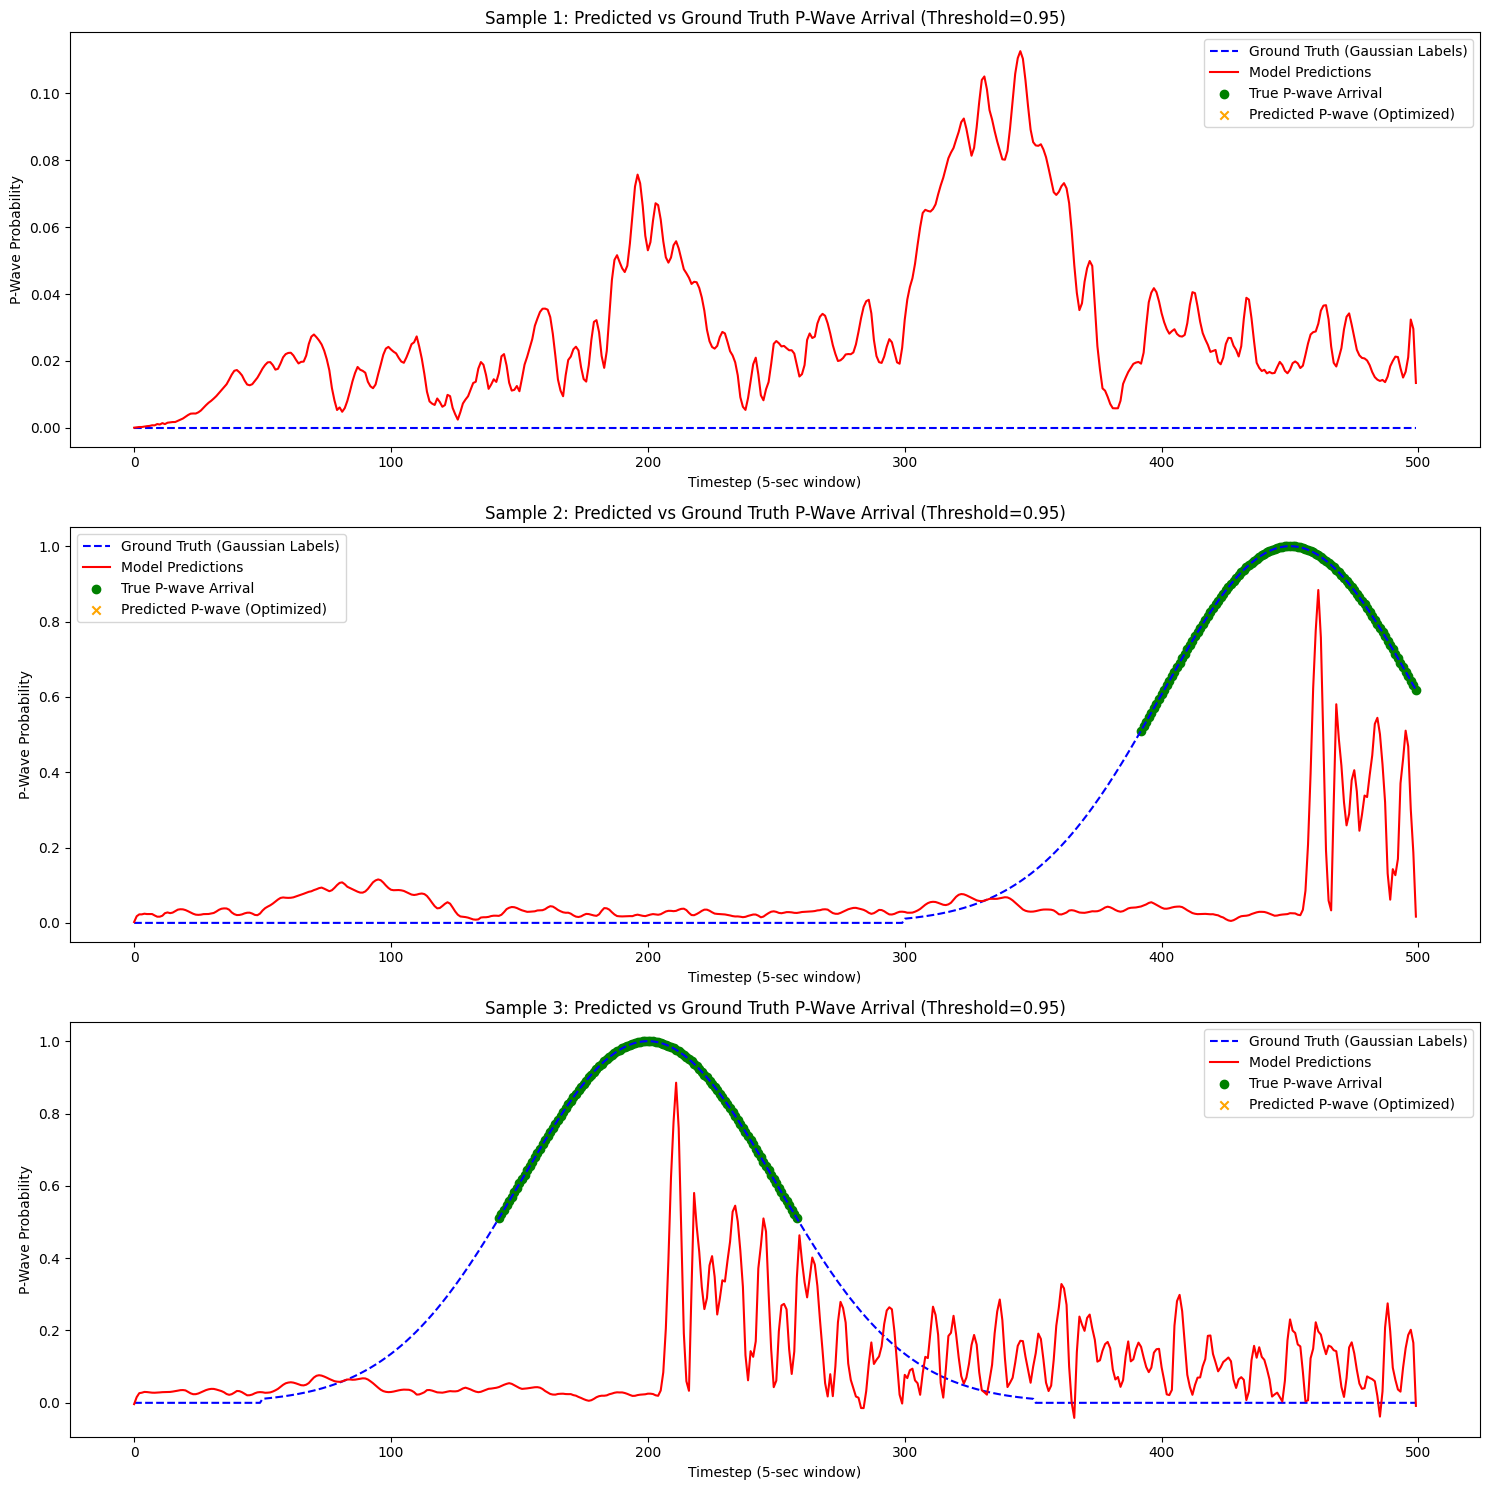

In [20]:
import matplotlib.pyplot as plt
import numpy as np


predictions = np.squeeze(predictions)


def calculate_accuracy(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_true_binary = (y_true >= 0.5).astype(int)  
    correct = (y_pred_binary == y_true_binary).sum()
    total = np.prod(y_true.shape)
    return correct / total


thresholds = np.arange(0.3, 1.0, 0.05)
accuracies = []

for threshold in thresholds:
    acc = calculate_accuracy(y_test_final, predictions, threshold)
    accuracies.append(acc)
    print(f"Threshold: {threshold:.2f}, Accuracy: {acc:.4f}")


best_threshold_idx = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_idx]
best_accuracy = accuracies[best_threshold_idx]

print("\nBest Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)

num_samples_to_plot = 3
selected_samples = range(num_samples_to_plot)

plt.figure(figsize=(15, 5 * num_samples_to_plot))

for i, sample_idx in enumerate(selected_samples):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    

    plt.plot(y_test_final[sample_idx], label="Ground Truth (Gaussian Labels)", linestyle="dashed", color="blue")
    
    plt.plot(predictions[sample_idx], label="Model Predictions", color="red")
    
    
    p_wave_indices = np.where(y_test_final[sample_idx] > 0.5)[0]
    plt.scatter(p_wave_indices, y_test_final[sample_idx, p_wave_indices], color="green", marker="o", label="True P-wave Arrival")
    
  
    pred_wave_indices = np.where(predictions[sample_idx] >= best_threshold)[0]
    plt.scatter(pred_wave_indices, predictions[sample_idx, pred_wave_indices], color="orange", marker="x", label="Predicted P-wave (Optimized)")

    plt.xlabel("Timestep (5-sec window)")
    plt.ylabel("P-Wave Probability")
    plt.title(f"Sample {i+1}: Predicted vs Ground Truth P-Wave Arrival (Threshold={best_threshold:.2f})")
    plt.legend()

plt.tight_layout()
plt.show()


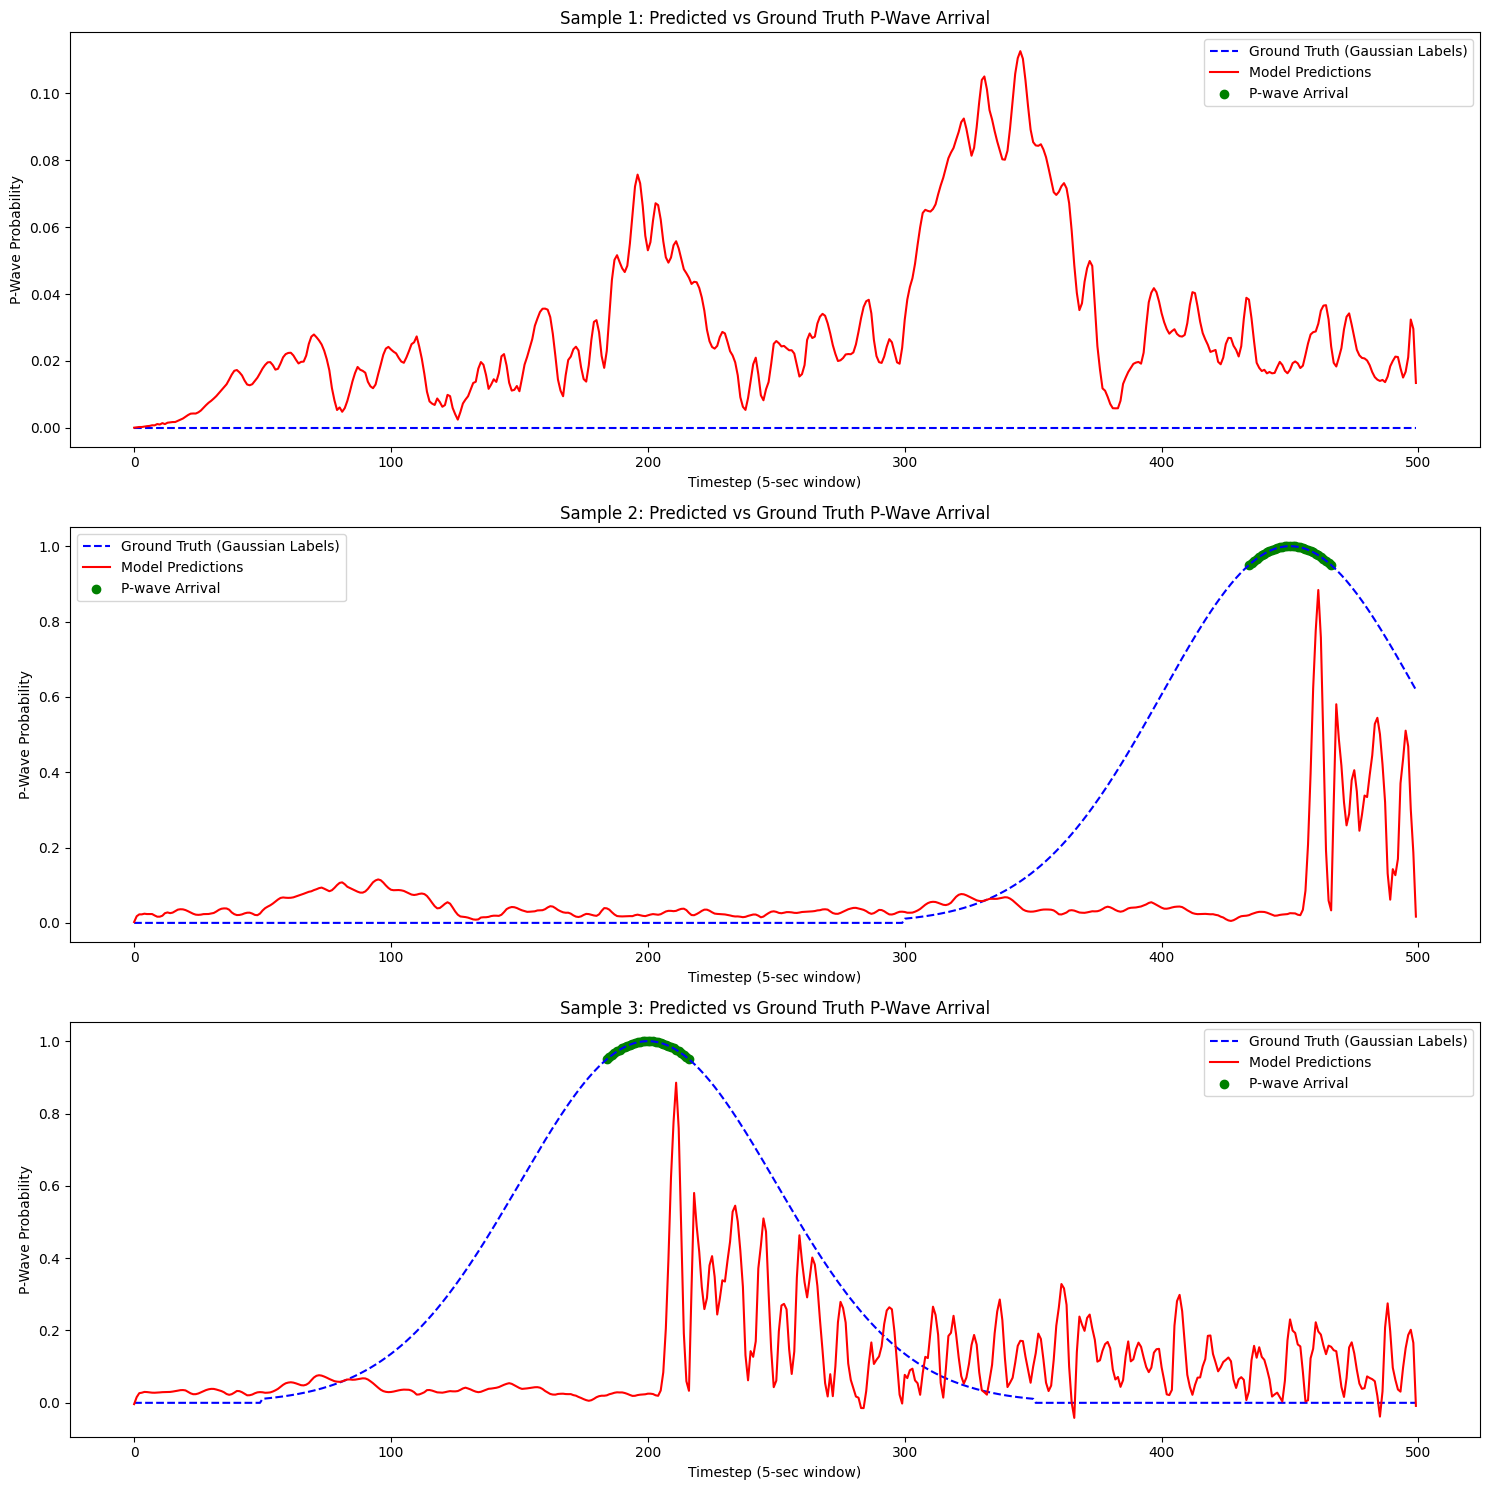

In [21]:
import matplotlib.pyplot as plt
import numpy as np


predictions = np.squeeze(predictions)

num_samples_to_plot = 3

selected_samples = range(num_samples_to_plot)

plt.figure(figsize=(15, 5 * num_samples_to_plot))

for i, sample_idx in enumerate(selected_samples):
    plt.subplot(num_samples_to_plot, 1, i + 1)

  
    plt.plot(y_test_final[sample_idx], label="Ground Truth (Gaussian Labels)", linestyle="dashed", color="blue")


    plt.plot(predictions[sample_idx], label="Model Predictions", color="red")

    
    p_wave_indices = np.where(y_test_final[sample_idx] > 0.95)[0]
    plt.scatter(p_wave_indices, y_test_final[sample_idx, p_wave_indices], color="green", marker="o", label="P-wave Arrival")

    plt.xlabel("Timestep (5-sec window)")
    plt.ylabel("P-Wave Probability")
    plt.title(f"Sample {i+1}: Predicted vs Ground Truth P-Wave Arrival")
    plt.legend()

plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_final.flatten(), predictions.flatten())
print(f"Mean Squared Error (MSE) between predictions and ground truth: {mse:.6f}")

Mean Squared Error (MSE) between predictions and ground truth: 0.024884
